<a href="https://colab.research.google.com/github/leechanwoo-kor/nlp/blob/main/rnn-classifier/RNN_Classifier_train_(pytorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 트위터 감정 분석

이번 실습에서는 트위터 메시지(트윗)의 감정을 분석하는 RNN Classifier를 만들겠습니다.

감정에는 긍정, 부정, 중립의 세 가지 레이블이 있습니다.

이 정의에 따라 트윗에 담긴 감정을 태깅하였고 이 데이터를 통해 주어진 트윗에 감정을 분석하는 classifier를 만드는 것이 이번 실습에서의 목표입니다.

이전 실습에서는 tensorflow로 작성하였다면 이번에는 또 다른 딥러닝 라이브러리인 [pytorch](https://pytorch.org/)로 작성하겠습니다.

이후 딥러닝 관련 실습에서는 pytorch로 진행하겠습니다.

pytorch와 tensorflow는 대동소이하여 예제로써 둘의 차이를 파악하시면 큰 어려움 없이 transfer learning을 하실 수 있으실 것입니다.

## 데이터 파일 다운로드

데이터 파일을 다운로드 하기 위해 특수 명령어인 gdown을 사용하였습니다.

In [ ]:
!gdown --id 1CElFsrPshUPyLIDk0MpkJR01cIcqNdra

!gdown --id 1tll145FRmWH8pfnlOCV_mYb3MTLvxf4K

!gdown --id 1WJOfcaaW_5nc0Dr573FhX5zFyC5NCp9Z

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1CElFsrPshUPyLIDk0MpkJR01cIcqNdra
To: /content/vocab.csv
100% 32.3k/32.3k [00:00<00:00, 41.3MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1tll145FRmWH8pfnlOCV_mYb3MTLvxf4K
To: /content/valid.csv
100% 31.5k/31.5k [00:00<00:00, 44.3MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https:/

`train.csv` 파일을 열어보면 한 라인에 두 개의 열이 있습니다. 

첫 번째 열에는 트위터 메시지인 트윗이 있고 오른쪽에는 태깅된 감정이 있습니다.

- 0: 부정
- 1: 중립
- 2: 긍정

이렇게 세 가지의 감정이 태깅된 것을 알 수 있습니다.

In [ ]:
with open("train.csv") as csv_f:
    head = "\n".join([next(csv_f) for x in range(5)])
print(head)

critic survey ashford hospit prime ahp amp kimco realti kim,0

analyst adopt bullish outlook robert half intern inc rhi,1

zack rank strong buy semiconductor stock mlnx intc mchp,2

setup like watch wed roku iq sfix shop spot ual goo twlo nflx xrt tsla sq bidu pypl labu biib kss kre,2

invesco ivz price target lower credit suiss group,1



## 라이브러리 로드

코드 실행에 필요한 라이브러리를 설치하고 로드합니다.

In [ ]:
!pip install -U torchtext==0.8.0

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchtext.data import Field, TabularDataset, BucketIterator
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim
from sklearn.metrics import classification_report
from nltk.tokenize import word_tokenize
import os
import nltk
from IPython.display import Image

## 모델 클래스 정의

pytorch는 딥러닝 모델의 forward path를 정의할 때는 반드시 `nn.Module` 클래스로부터 상속을 받아 새로운 클래스로 만들어야 합니다.

그리고 그 forward path를 정의하기 위해 반드시 `forward` 함수를 정의하여야 합니다.

이번 실습에서는 RNN을 이용한 classifier이기에 그에 적합한 클래스를 작성하였습니다.

- 문제 1. `LSTMClassifier` 클래스 내 model 구성에 있어 마지막에 classification을 위해 dense layer를 추가해주세요. 
  - 힌트 1) class의 개수는 3개입니다. 
  - 힌트 2) dense layer는 `nn.Linear`([매뉴얼 문서](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html))로 만들 수 있습니다.
  - 힌트 3) LSTM은 bidirection 즉, 양방향입니다.

In [ ]:
class LSTMClassifier(nn.Module):
    # LSTM Classifier 클래스를 정의합니다. Pytorch는 모델을 구성할 때 반드시 nn.Module 클래스를 상속받은 후 이를 토대로 만듭니다.
    def __init__(self, vocab_size, dimension=128):
        # 클래스의 첫 시작인 함수입니다. 여기서 모델에 필요한 여러 변수들을 정의합니다.
        super(LSTMClassifier, self).__init__()

        # LSTM Classifier에 필요한 변수들을 각각 정의합니다.
        self.embedding = nn.Embedding(vocab_size, 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300, hidden_size=dimension, num_layers=1, batch_first=True, bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 3)

    def forward(self, text, text_len):
        # 모델의 forward feed를 수행하는 함수입니다.
        # text와 text_len 변수를 입력으로 받아 신경망 모델을 forward 방향으로 탈 때 그 출력을 반환합니다.
        # 단어 => encoder => Embedding => 양방향 RNN => Dense => Dense의 구조입니다.
        text_emb = self.embedding(text) # B, N, 300

        # 글마다 길이가 다르기에 이를 하나의 batch에서 사용하고자 pack_padded_sequence 함수를 통해 padding을 수행합니다.
        packed_input = pack_padded_sequence(text_emb, text_len.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1) # B, 2*dimension
        text_fea = self.drop(out_reduced)

        # <ToDo>: model의 마지막에 classification을 위해 dense layer를 추가해주세요.
        text_out = self.fc(text_fea) # B, 3

        return text_out

## train 함수

해당 함수에서는 정의된 `model` 클래스의 인스턴스를 가져와서 이를 train data로 학습시킵니다. 그리고 validation data로 학습 중간에 성능을 평가합니다.

In [ ]:
def train(model, device, optimizer, train_loader, valid_loader, output_file_path, num_epochs):
    # 학습에 필요한 변수들을 기본적으로 정의합니다.
    running_loss = 0.0
    global_step = 0
    train_loss_list = list()
    valid_loss_list = list()
    global_steps_list = list()
    loss_fn = nn.CrossEntropyLoss()
    best_valid_loss = float("Inf")
    eval_every = 10

    # model에게 학습이 진행됨을 알려줍니다.
    model.train()
    # num_epochs만큼 epoch을 반복합니다.
    for epoch in range(num_epochs):
        # train_loader를 읽으면 정해진 데이터를 읽어옵니다.
        for ((text, text_len), labels), _ in train_loader:
            # 데이터를 GPU로 옮깁니다.
            text = text.to(device)
            text_len = text_len.to(device)
            labels = labels.to(device)
            
            # model을 함수처럼 호출하면 model에서 정의한 forward 함수가 실행됩니다.
            # 즉, 데이터를 모델에 집어넣어 forward방향으로 흐른 후 그 결과를 받습니다.
            output = model(text, text_len)

            # forward 결과와 실제 데이터 결과의 차이를 정의한 loss 함수로 구합니다.
            loss = loss_fn(output, labels)

            # 최적화 수행
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            global_step += 1

            if global_step % eval_every == 0:
                # 100번에 한 번으로 validation 데이터를 이용하여 성능을 검증합니다.
                average_train_loss, average_valid_loss = evaluate(model, device, valid_loader, loss_fn,
                                                                  running_loss, eval_every)
                
                # 검증이 끝난 후 다시 모델에게 학습을 준비시킵니다.
                running_loss = 0.0
                model.train()

                # 결과 출력
                print('Epoch {}, Step {}, Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch + 1, global_step, average_train_loss, average_valid_loss))

                # 결과 저장
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # 만약 기존 것보다 성능이 높게 나왔다면 현재 모델 상태를 저장합니다.
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(output_file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(output_file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)

    # 결과를 저장합니다.
    save_metrics(output_file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)

## evaluate 함수

해당 함수에서는 validation data를 이용하여 학습된 `model`을 평가합니다.

In [ ]:
def evaluate(model, device, valid_loader, loss_fn, running_loss, eval_every):
    # 학습 중 모델을 평가합니다.
    # 모델에게 학습이 아닌 평가를 할 것이라고 알립니다.
    model.eval()
    valid_running_loss = 0.

    # 학습이 아니기에 최적화를 하지 않는다는 환경을 설정합니다.
    with torch.no_grad():
        # validation 데이터를 읽습니다.
        for ((text, text_len), labels), _ in valid_loader:
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            
            # model을 함수처럼 호출하면 model에서 정의한 forward 함수가 실행됩니다.
            # 즉, 데이터를 모델에 집어넣어 forward방향으로 흐른 후 그 결과를 받습니다.
            output = model(text, text_len)

            # validation 데이터의 loss, 즉 모델의 출력과 실제 데이터의 차이를 구합니다.
            loss = loss_fn(output, labels)
            valid_running_loss += loss.item()

    # 평균 loss를 계산합니다.
    average_train_loss = running_loss / eval_every
    average_valid_loss = valid_running_loss / len(valid_loader)

    return average_train_loss, average_valid_loss

## 그래프 그리는 함수

epoch에 따른 train loss와 validation loss 그래프를 그립니다.

In [ ]:
def draw_graph(output_file_path, device):
    train_loss_list, valid_loss_list, global_steps_list = load_metrics(output_file_path + '/metrics.pt', device)
    plt.plot(global_steps_list, train_loss_list, label='Train')
    plt.plot(global_steps_list, valid_loss_list, label='Valid')
    plt.xlabel('Global Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig("train_valid_loss.png", bbox_inches='tight')

    Image('train_valid_loss.png')

## 모델 및 기록 저장 불러오기

In [ ]:
def save_checkpoint(save_path, model, optimizer, valid_loss):
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}

    torch.save(state_dict, save_path)


def load_checkpoint(load_path, model, optimizer, device):
    state_dict = torch.load(load_path, map_location=device)

    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])

    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}

    torch.save(state_dict, save_path)


def load_metrics(load_path, device):
    state_dict = torch.load(load_path, map_location=device)

    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

## 데이터 불러오기

- 문제 2. `valid_loader`를 불러오세요. 힌트) `train_loader`을 참고하세요.

In [ ]:
# nltk의 토크나이저를 사용하기에 이를 다운로드 받습니다.
nltk.download('punkt')

# 데이터의 기본 형태에 대한 정보입니다.
output_file_path="./model/"
os.makedirs(output_file_path, exist_ok=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.long)
text_field = Field(tokenize=word_tokenize, lower=True, include_lengths=True, batch_first=True)
fields = [('text', text_field), ('labels', label_field)]

# train, validation 데이터 csv 파일을 읽어옵니다.
train_data, valid_data = TabularDataset.splits(path="./", train='train.csv', validation='valid.csv',
                                               format='CSV', fields=fields, skip_header=True)
train_loader = BucketIterator(train_data, batch_size=32, sort_key=lambda x: len(x.text),
                              device=device, sort=True, sort_within_batch=True)

# <ToDo>: valid_dataset을 불러오세요.
valid_loader = BucketIterator(valid_data, batch_size=32, sort_key=lambda x: len(x.text),
                              device=device, sort=True, sort_within_batch=True)

text_field.build_vocab(train_data, min_freq=3)
vocab_size = len(text_field.vocab)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warn

## 모델 학습

- 문제 3. `train` 함수를 이용하여 train data를 통해 모델 학습을 진행하세요.

In [ ]:
# 앞서 정의한 LSTMClassifier 클래스의 인스턴스를 만듭니다.
model = LSTMClassifier(vocab_size).to(device)
# Adam optimizier를 사용합니다.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# <ToDo>: 학습을 위해 train 함수의 적절한 parameter를 전달해주세요.
train(model, device, optimizer, train_loader, valid_loader, output_file_path, num_epochs=10)

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch 1, Step 10, Train Loss: 0.9601, Valid Loss: 0.9364
Epoch 1, Step 20, Train Loss: 0.8413, Valid Loss: 0.9492
Epoch 1, Step 30, Train Loss: 0.9589, Valid Loss: 0.8317
Epoch 1, Step 40, Train Loss: 0.9440, Valid Loss: 0.7730
Epoch 1, Step 50, Train Loss: 0.8758, Valid Loss: 0.8001
Epoch 1, Step 60, Train Loss: 0.9477, Valid Loss: 0.7516
Epoch 2, Step 70, Train Loss: 0.6107, Valid Loss: 0.7037
Epoch 2, Step 80, Train Loss: 0.5029, Valid Loss: 0.7371
Epoch 2, Step 90, Train Loss: 0.6269, Valid Loss: 0.7178
Epoch 2, Step 100, Train Loss: 0.6207, Valid Loss: 0.6418
Epoch 2, Step 110, Train Loss: 0.6680, Valid Loss: 0.6336
Epoch 2, Step 120, Train Loss: 0.7226, Valid Loss: 0.6720
Epoch 3, Step 130, Train Loss: 0.5204, Valid Loss: 0.5696
Epoch 3, Step 140, Train Loss: 0.3161, Valid Loss: 0.5982
Epoch 3, Step 150, Train Loss: 0.3560, Valid Loss: 0.6406
Epoch 3, Step 160, Train Loss: 0.3257, Valid Loss: 0.5325
Epoch 3, Step 170, Train Loss: 0.3880, Valid Loss: 0.5164
Epoch 3, Step 180, Trai

## 결과 출력

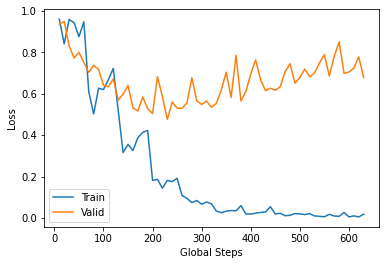

In [ ]:
draw_graph(output_file_path, device)

## 추가 질문

위의 그림을 보면서 최적의 Epoch 개수를 찾아보세요.

Valid Loss가 가장 적은 부분을 찾아보았을 때,
200과 250 사이의 Global Steps 값을 갖는 Epoch 4가 가장 최적의 Epoch 개수이다.